In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter, spectrogram
from sklearn.metrics import mean_squared_error


In [2]:
fs = 16000
duration = 2
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
clean_signal = np.sin(2 * np.pi * 300 * t) + 0.6 * np.sin(2 * np.pi * 1000 * t)

white_noise = 0.3 * np.random.randn(len(t))
hum_50hz = 0.3 * np.sin(2 * np.pi * 50 * t)
noise = white_noise + hum_50hz
noisy_signal = clean_signal + noise

sf.write("C:/Users/tripl/Desktop/sound.wav", noisy_signal, fs)


In [3]:
def butter_filter(cutoff, fs, order=5, filter_type='low'):
    nyq = 0.5 * fs
    norm_cutoff = np.array(cutoff) / nyq if isinstance(cutoff, (list, tuple)) else cutoff / nyq
    b, a = butter(order, norm_cutoff, btype=filter_type, analog=False)
    return b, a

def apply_filter(data, cutoff, fs, order=5, filter_type='low'):
    b, a = butter_filter(cutoff, fs, order, filter_type)
    filtered = lfilter(b, a, data)
    if np.std(filtered) > 0:
        filtered = filtered * (np.std(data) / np.std(filtered))
    return filtered


In [4]:
low_filtered = apply_filter(noisy_signal, cutoff=4000, fs=fs, order=2, filter_type='low')
band_stopped = apply_filter(noisy_signal, cutoff=[40, 60], fs=fs, order=3, filter_type='bandstop')
combined_filtered = apply_filter(band_stopped, cutoff=4000, fs=fs, order=2, filter_type='low')

sf.write("lowpass_filtered.wav", low_filtered, fs)
sf.write("bandstop_filtered.wav", band_stopped, fs)
sf.write("combined_filtered.wav", combined_filtered, fs)


In [5]:
def calculate_snr(clean, noisy):
    power_signal = np.mean(clean ** 2)
    power_noise = np.mean((clean - noisy) ** 2)
    if power_noise < 1e-10 or power_signal < 1e-10:
        return float('inf')
    return 10 * np.log10(power_signal / power_noise)

snr_before = calculate_snr(clean_signal, noisy_signal)
snr_low = calculate_snr(clean_signal, low_filtered)
snr_bandstop = calculate_snr(clean_signal, band_stopped)
snr_combined = calculate_snr(clean_signal, combined_filtered)

mse_low = mean_squared_error(clean_signal, low_filtered)
mse_bandstop = mean_squared_error(clean_signal, band_stopped)
mse_combined = mean_squared_error(clean_signal, combined_filtered)


In [6]:
if (snr_low < snr_before - 0.1) or (snr_bandstop < snr_before - 0.1) or (snr_combined < snr_before - 0.1):
    print("Warning: One of the filters degraded the signal quality by more than 0.1 dB. You may need to adjust the cutoff or filter order.")

print(f"SNR before filtering: {snr_before:.2f} dB")
print(f"SNR after Low-pass: {snr_low:.2f} dB")
print(f"SNR after Band-stop: {snr_bandstop:.2f} dB")
print(f"SNR after Combined: {snr_combined:.2f} dB")
print(f"MSE (Low-pass): {mse_low:.6f}")
print(f"MSE (Band-stop): {mse_bandstop:.6f}")
print(f"MSE (Combined): {mse_combined:.6f}")


SNR before filtering: 7.01 dB
SNR after Low-pass: 7.73 dB
SNR after Band-stop: 8.10 dB
SNR after Combined: 10.15 dB
MSE (Low-pass): 0.114793
MSE (Band-stop): 0.105316
MSE (Combined): 0.065731


In [7]:
def plot_all(signal, title, color='blue'):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t[:800], signal[:800], color=color)
    plt.title(f"{title} - Time Domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid()

    plt.subplot(3, 1, 2)
    N = len(signal)
    fft_vals = np.abs(np.fft.fft(signal))[:N//2]
    fft_freqs = np.fft.fftfreq(N, 1/fs)[:N//2]
    plt.plot(fft_freqs, fft_vals, color=color)
    plt.title(f"{title} - Frequency Domain")
    plt.xlim(0, 2000)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid()

    plt.subplot(3, 1, 3)
    f, t_spec, Sxx = spectrogram(signal, fs, nperseg=512, noverlap=256, nfft=512, scaling='spectrum', detrend='constant', window='hann', mode='magnitude')
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    plt.title(f"{title} - Spectrogram")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='dB')
    plt.ylim(0, 2000)

    plt.tight_layout()
    plt.show()


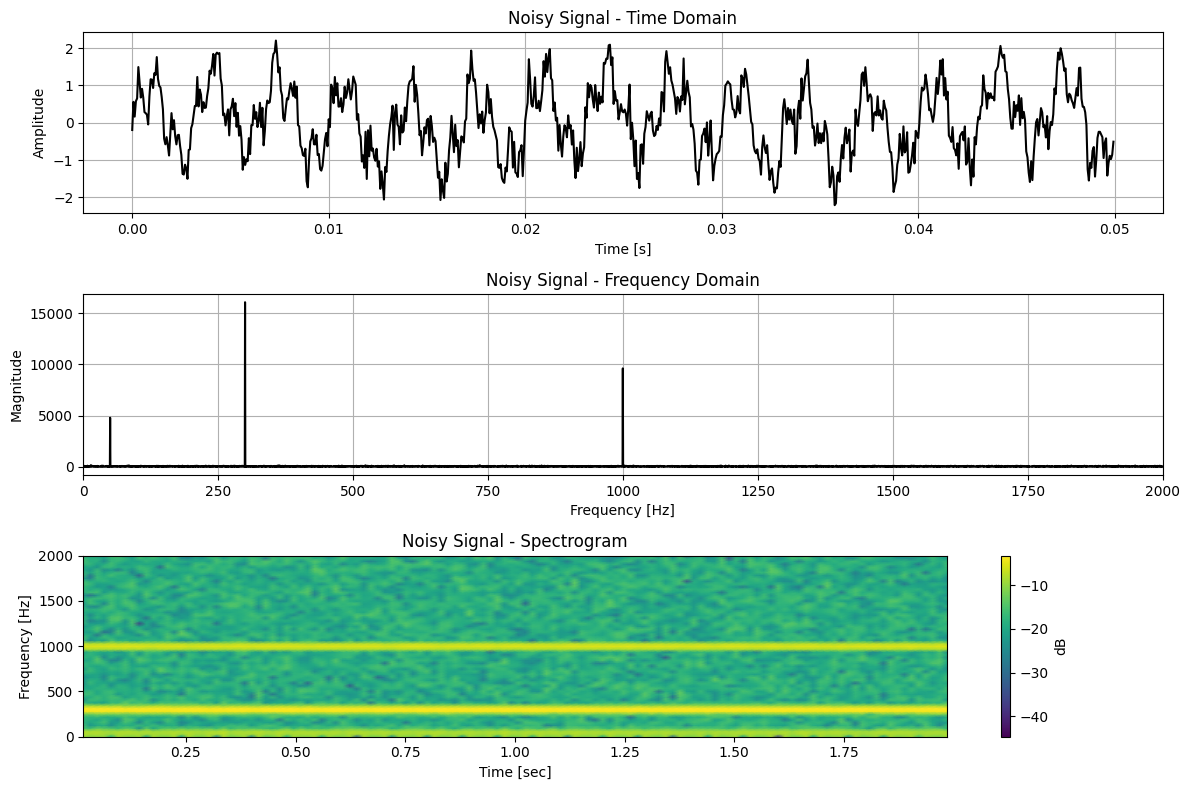

In [9]:
plot_all(noisy_signal, "Noisy Signal", 'black')

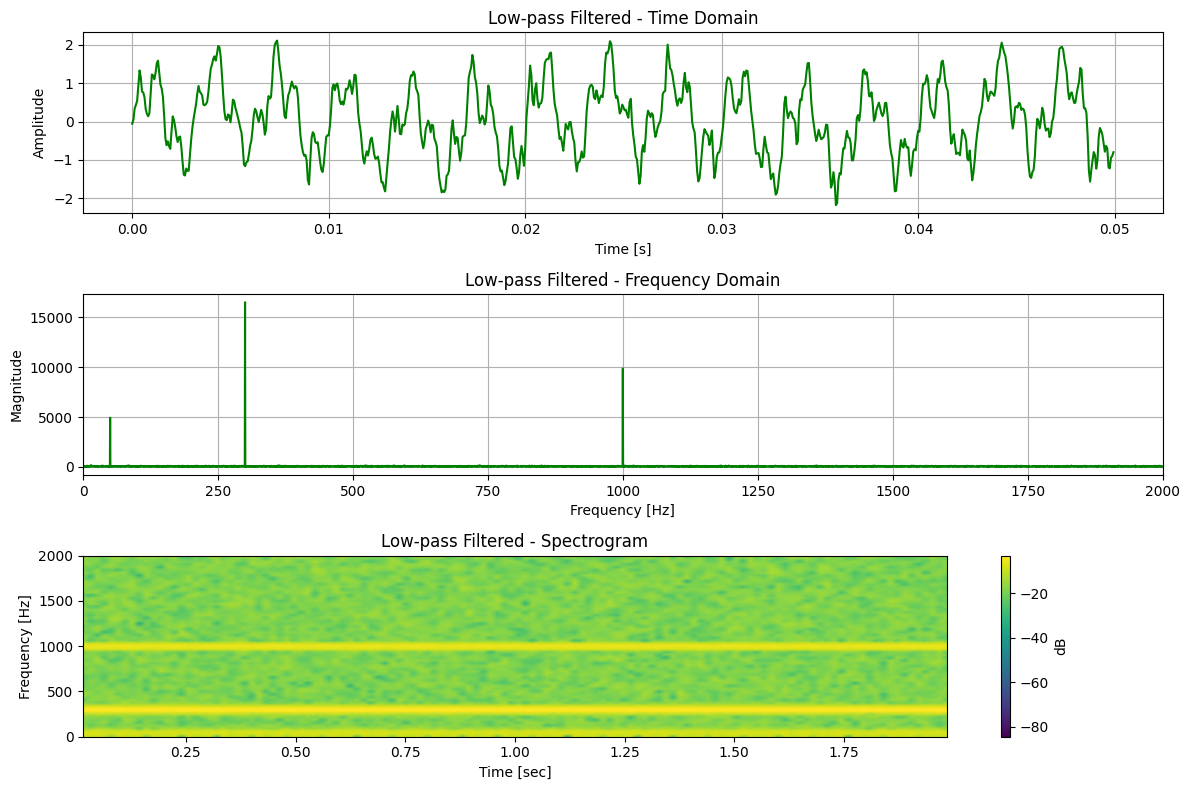

In [10]:
plot_all(low_filtered, "Low-pass Filtered", 'green')

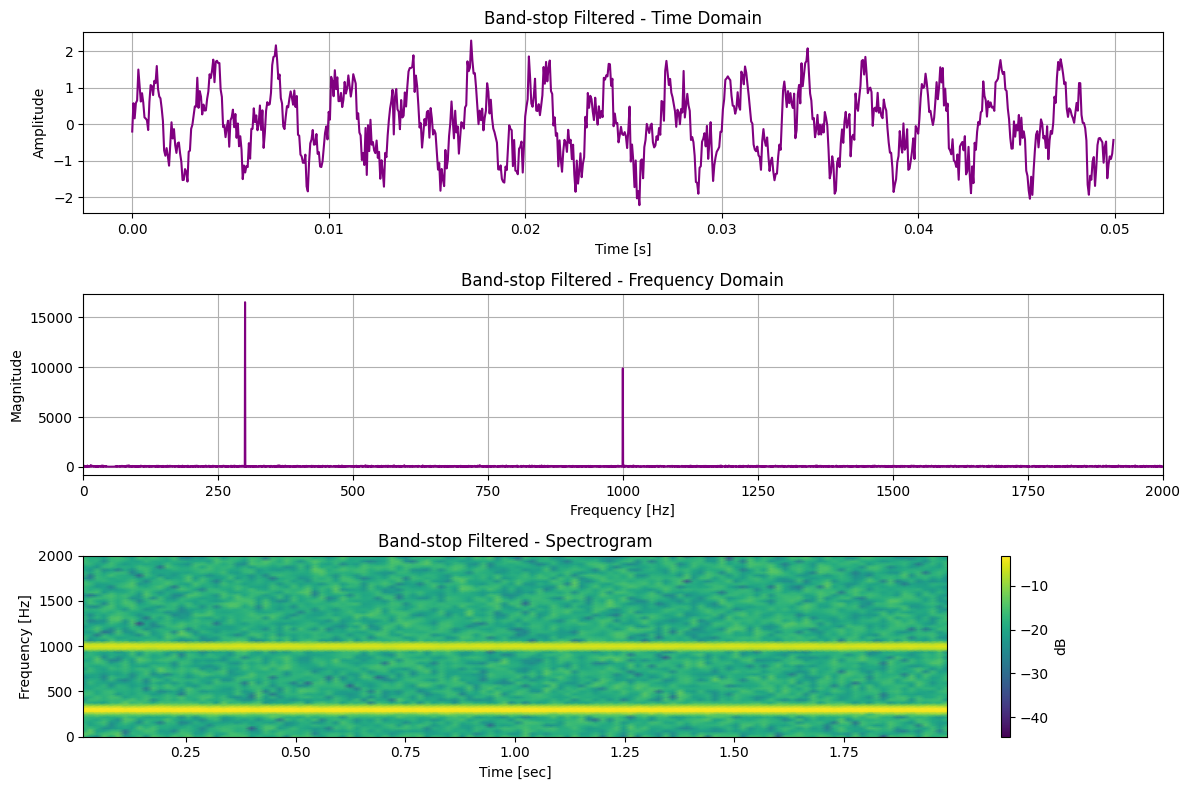

In [11]:
plot_all(band_stopped, "Band-stop Filtered", 'purple')

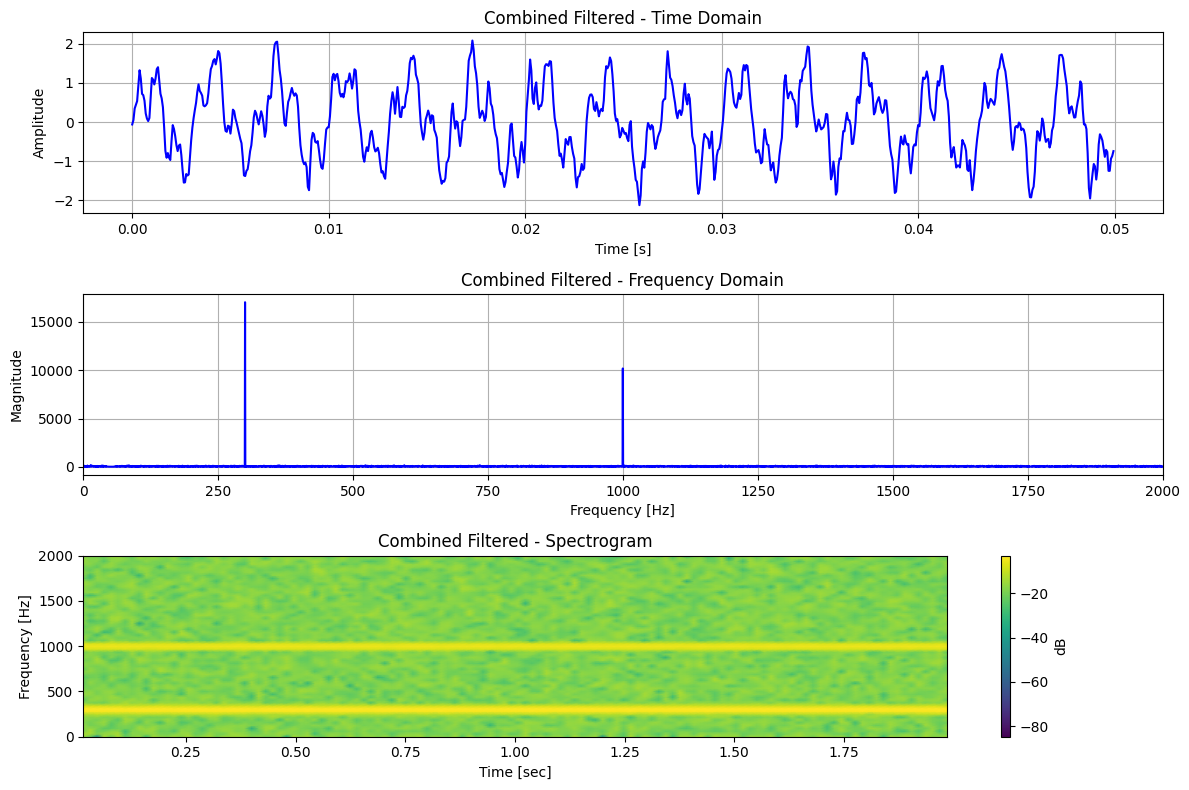

In [12]:
plot_all(combined_filtered, "Combined Filtered", 'blue')